# Implementation of MLP model for Grokking



## Data Generation

The input expected is a $2p$ dimensional vector of one hot encoded representation of the inputs in $\mathbb{Z}_p$. Also, the parameter $\alpha$ which determines how the data is split into train/test (i.e. $\alpha$ % of data is used for training).

In [ ]:
from sklearn.model_selection import train_test_split
import torch
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def is_prime(num: int) -> bool:
    """
    returns True if a number is prime and False otherwise
    """
    # Input validation
    assert isinstance(num, int), 'Expected an integer data type'
    t = 1
    if num <= 1 :
        return False
    else:
        for m in range (2, int(num**0.5)+1) :
            t = (num % m)
            if t == 0:
                return False
    return True

def division_mod_p(operand1: int, operand2: int, p: int) -> int:
    """
    returns (operand1 / operand2) % p
    """
    # Input validation
    assert isinstance(operand1, int), 'Expected an integer data type'
    assert isinstance(operand2, int), 'Expected an integer data type'
    assert isinstance(p, int), 'Expected an integer data type'
    assert is_prime(p), 'Expected a prime number'
    assert (operand2 % p != 0), 'Division by zero'

    # Algorithm
    check = operand1
    while check % operand2 != 0:
        check += p
    return (check//operand2) % p

def exponent_mod_p(base: int, exponent: int, p: int) -> int:
    """
    returns (base ** exponent) % p
    """
    # Input validation
    assert isinstance(base, int), 'Expected an integer data type'
    assert isinstance(exponent, int), 'Expected an integer data type'
    assert isinstance(p, int), 'Expected an integer data type'
    if exponent < 0:
        assert (base % p != 0), 'Division by zero'

    # Algorithm
    if exponent < 0:
        return division_mod_p(1, base ** (-exponent), p)
    return (base ** exponent) % p

OPERATIONS = {
    "x+y"   : lambda x, y, p: (x + y)%p,
    "x-y"   : lambda x, y, p: (x - y)%p,
    "x*y"   : lambda x, y, p: (x * y)%p,
    "x/y"   : lambda x, y, p: division_mod_p(x, y, p),
    "x^y"   : lambda x, y, p: exponent_mod_p(x, y, p), # Note! 0^0 = 1
    "2x-y"  : lambda x, y, p: (2*x - y)%p,
"2**x+y**2" : lambda x, y, p: (2**x + y**2)%p,
 "x^2+y^2"  : lambda x, y, p: (x**2 + y**2)%p,
"x^3+xy^2+y": lambda x, y, p: (x**3 + x*(y**2) + y)%p,
    "const" : lambda x, y, p: 1,
    "rand"  : lambda x, y, p: random.randint(0, p-1),
  "x^y+y^x" : lambda x, y, p: (x**y + y**x)%p,
    "chess" : lambda x, y, p: (x+y)%2,
    "diag"  : lambda x, y, p: int(x==y),
}

LATEX = {
    "x+y"   : "$(x+y) \\mathbb{Z}_p$",
    "x-y"   : "$(x-y) \\mathbb{Z}_p$",
    "x*y"   : "$(xy) \\mathbb{Z}_p$",
    "x/y"   : "$(\\frac{x}{y}) \\mathbb{Z}_p$",
    "x^y"   : "$(x^y) \\mathbb{Z}_p$", # Note! 0^0 = 1
    "2x-y"  : "$(2x-y) \\mathbb{Z}_p$",
"2**x+y**2" : "$(2^x+y^2) \\mathbb{Z}_p$",
"x^2+y^2"   : "$(x^2+y^2) \\mathbb{Z}_p$",
"x^3+xy^2+y": "$(x^3+xy^2+y) \\mathbb{Z}_p$",
    "const" : "$constant \\mathbb{Z}_p$",
    "rand"  : "$rand \\mathbb{Z}_p$",
  "x^y+y^x" : "$(x^y+y^x) \\mathbb{Z}_p$",
    "chess" : "$chess \\mathbb{Z}_p$",
    "diag"  : "$diag \\mathbb{Z}_p$",
}

omit = {"x/y", "2**x+1/y"}

tups = []           # Get the inputs
outs = []           # Get the outputs
train_inputs = []   # Get the inputs used in training
test_inputs = []    # Get the inputs used in testing
train_outputs = []  # Get the outputs used in training
test_outputs = []   # Get the outputs used in testing

def one_hot(input: int, p: int) -> list: # torch.Tensor:
    """
    Returns a one hot coded representation of input with respect to p.
    """

    # Input validation
    assert isinstance(input, int), 'Expected an integer data type'
    assert isinstance(p, int), 'Expected an integer data type'
    assert input < p, 'Expected inputs from Zp'
    assert input >= 0, 'Expected inputs from Zp'

    out = [0 for _ in range(p)]
    out[input] = 1
    return out

def grok_data(operation: str, p: int, alpha: float) -> tuple:
    """
    Generates data for model

    Parameters:
    operation        : A string for the type of modular operation
    p                : The prime number
    alpha            : Frcation by which to split the data into training and test
    """

    global tups
    global outs
    global train_inputs
    global test_inputs
    global train_outputs
    global test_outputs

    assert isinstance(alpha, float), 'Expected a float data type'
    assert (alpha < 1 and alpha > 0), 'Alpha should be between 0 and 1'

    labels = []

    x = [i for i in range(p)]
    if operation not in omit:
        y = [i for i in range(p)]
    else:
        y = [i for i in range(1, p)]

    tups.clear()
    outs.clear()
    for op1 in x:
        for op2 in y:
            tups.append((op1, op2))
            labels.append(OPERATIONS[operation](op1, op2, p))
            outs.append(OPERATIONS[operation](op1, op2, p))

    train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(tups, labels, random_state=42,
                                                      test_size=1-alpha, shuffle=True)

    X_train = [one_hot(op1, p)+one_hot(op2, p) for (op1, op2) in train_inputs]
    X_test = [one_hot(op1, p)+one_hot(op2, p) for (op1, op2) in test_inputs]
    y_train = [one_hot(y, p) for y in train_outputs]
    y_test = [one_hot(y, p) for y in test_outputs]

    return (X_train, y_train), (X_test, y_test)

## MLP

Here I implemented the MLP taking a hint from what was described in [Andrey Gromov's paper](https://arxiv.org/pdf/2301.02679), but the output of the final layer is projected on the $\mathbb{R}^p$ unit ball using the $L_2$ norm. I observed this to have the best performance so far. (Outperformed using softmax or $L_1$ projection). The intuition came from the fact that one hot encoding transforms the inputs to points on the unit ball in $\mathbb{R}^p$ and so, I believed limiting the codomain of the neural network would help it learn better. I used the cross entropy loss function and ReLu activation function.

Unlike the suggestion in the paper by Andrey, I did not need to consider the starting condition of the parameters. Also, using MSE loss gave bad performance. I also observed that having the hidden dimension to be about $\approx < 5prime$ has the best performance. I do not know why exactly but I guess that having more parameters than necessary in a wide network slows down learning as it will have to send some weights to zero. I feel drop out as a regularisation method could help solve this issue though I have not tested this yet.

***Innovation (new original idea)***: The projection on the $L_2$ unit ball.

***Further Analysis***: Could this be a very good type of activation function that gives more stability to the neural network?

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class quadratic_activation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * x

class unit_ball_proj_l2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x/torch.linalg.vector_norm(x)

class stab_max(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.log(nn.ReLU()(x) + 1.0)-torch.log(nn.ReLU()(-x) + 1.0)

class MLP_Grok(nn.Module):
    def __init__(self, prime, hidden_dim):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)
        self.contract = unit_ball_proj_l2()

    def forward(self, x):
        return self.contract(self.output(self.activation(self.input(x))))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

class MLP_Grok1(nn.Module): # Model without post-logit activation
    def __init__(self, prime, hidden_dim):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok1, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)

    def forward(self, x):
        return self.output(self.activation(self.input(x)))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

class MLP_Grok3(nn.Module): # Model with drop out
    def __init__(self, prime, hidden_dim, drop_out):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok3, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)
        self.reg = nn.Dropout(drop_out)

    def forward(self, x):
        return self.reg(self.output(self.reg(self.activation(self.input(x)))))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

class MLP_Grok4(nn.Module): # Model prieto
    def __init__(self, prime, hidden_dim):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok4, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)
        self.out = stab_max()

    def forward(self, x):
        return self.out(self.output(self.activation(self.input(x))))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

## Data collection during training

Here, I introduce a function, ```grokking_epoch```, to measure the epoch grokking occurs given two thresholds $\in [0; 1]$. For example, with a ```threshold1``` of $0.9$, and a ```threshold2``` of $0.8$ the gap between the train and test accuracies should have been up to $0.9$ at some epoch, and the test accuracy must have reached $0.8$ within the allocated number of epochs. It returns ```None``` otherwise.

I also introduce a function, ```rate_of_change```, to measure the rate of change of the accuracies and losses per epoch.

I used stochastic gradient descent.


In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim

model = None

def experiment(prime: int, operation: str, # positional arguments
               hidden_dim: int = 500,
               epochs: int = 1_000,
               alpha: float = 0.5,
               criterion = nn.CrossEntropyLoss(reduction='sum'),
               weight_decay: float = 0.0,
               seed = 42):
    '''
    Returns train_acc, test_acc, train_loss, test_loss, weight_norm
    '''

    global model
    global device

    torch.manual_seed(seed)
    if not model: # Else to continue previous training session if necessary
        model = MLP_Grok(prime, hidden_dim)
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)

    # Make sure model is on device
    model.to(device)

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    weight_norm = []

    train_set, test_set = grok_data(operation, prime, alpha)
    X_train, y_train = train_set
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)

    X_test, y_test = test_set
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device, requires_grad=False)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device, requires_grad=False)

    for epoch in tqdm(range(epochs)):
        # Train mode
        model.train()

        outputs = model(X_train)
        acc = (torch.argmax(outputs, dim=1) == torch.argmax(y_train, dim=1)).float().mean()
        loss = criterion(outputs, y_train)

        # Backtrack and calculate gradients
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        # Record loss and accuracies
        train_loss.append(loss.cpu().item())
        train_acc.append(acc.cpu().item())

        model.eval()
        with torch.no_grad():

            outputs = model(X_test)
            acc = (torch.argmax(outputs, dim=1) == torch.argmax(y_test, dim=1)).float().mean()
            loss = criterion(outputs, y_test)

            test_loss.append(loss.cpu().item())
            test_acc.append(acc.cpu().item())

            W_norm = 0.0

            for name, W in model.named_parameters():
                if 'weight' in name:
                    W_norm += W.norm(2)
            weight_norm.append(W_norm.cpu().item())

        if test_acc[-1] == 1.0:
            print("=====================================")
            print('Early stopping: Test accuracy is 100%')
            print("=====================================")
            break

        if epoch % 1000 == 0:
            print("Test accuracy  -> ", test_acc[-1])
            print("Train accuracy -> ", train_acc[-1])

    return train_acc, test_acc, train_loss, test_loss, weight_norm

def grokking_epoch(threshold1, threshold2, train_acc, test_acc):
    # If the required gap between train/test accuracy is not reached
    # Pick the epoch with largest available gap and print "threshold1 not reached"
    # If required test accuracy is not reached
    # Pick the epoch with the highest available accuracy and print "threshold2 not reached"

    start_epoch = 0
    end_epoch = 0
    for epoch in range(len(train_acc)):
        if (train_acc[epoch] - test_acc[epoch]) >= threshold1:
            start_epoch = epoch+1
        if test_acc[epoch] >= threshold2:
            end_epoch = epoch+1

    if start_epoch == 0:
        a = np.array(train_acc)
        b = np.array(test_acc)
        c = a-b
        temp1  = np.argmax(c)+1
        if end_epoch != 0:
            start_epoch = temp1
            print('======================')
            print("threshold1 not reached")
            print('======================')
            print()
            print('=======================================================================================')
            print(f"Largest gap between accuracies of train and test is {c[temp1-1]} at epoch {temp1}")
            print('=======================================================================================')
            # return start_epoch, end_epoch

    if end_epoch == 0:# test_acc[end_epoch-1] <= threshold2:
        b = np.array(test_acc)
        temp2 = np.argmax(b)+1
        if start_epoch != 0:
            end_epoch = temp2
            print('======================')
            print("threshold2 not reached")
            print('======================')
            print()
            print('===============================================================')
            print(f"Highest test accuracy is {b[temp2-1]} at epoch {temp2}")
            print('===============================================================')
            # return start_epoch, end_epoch

    if start_epoch == 0 and end_epoch == 0:
        print('=====================================')
        print("threshold1 and threshold2 not reached")
        print('=====================================')
        print()
        print('==================================================================================')
        print(f"Largest gap between accuracies of train and test is {c[temp1-1]} at epoch {temp1}")
        print('==================================================================================')
        print()
        print('=========================================================')
        print(f"Highest test accuracy is {b[temp2-1]} at epoch {temp2}")
        print('=========================================================')
        return temp1, temp2

    return start_epoch, end_epoch

def rate_of_change(data):

    global model
    global tups
    global train_inputs
    global test_inputs

    l = len(data)
    out = []
    for i in range(l-1):
        out.append(data[i+1]-data[i])
    return out

def plots(train_acc,
          test_acc,
          train_loss,
          test_loss,
          weight_norm,
          prime,
          operation,
          alpha,
          threshold1=0.9, threshold2=0.85):

    train_acc_rate  = rate_of_change(train_acc)
    test_acc_rate   = rate_of_change(test_acc)
    train_loss_rate = rate_of_change(train_loss)
    test_loss_rate  = rate_of_change(test_loss)

    grok_epoch = grokking_epoch(threshold1, threshold2, train_acc, test_acc)
    start_epoch = 0
    end_epoch = len(test_acc)

    if grok_epoch:
        start_epoch = grok_epoch[0]
        end_epoch = grok_epoch[1]
    else:
        print('=====================================================================================================')
        print(f'Threshold not achieved, using default start and end epoch of {start_epoch} and {end_epoch}, respectively')
        print('=====================================================================================================')

    print()
    print('=================================')
    print(int(alpha*100), '% of data for training')
    print('=================================')
    print()
    # Plots from MatPlotlib
    xs = [i+1 for i in range(len(train_acc))]
    plt.plot(xs, weight_norm, label = 'weight_norm')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Norm')
    plt.title(f'$L_2$ Norm of the weight matrix of the neural network $p=${prime}: ' + LATEX[operation])
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_loss.png')
    plt.show()

    plt.plot(xs, train_acc, label = 'Train')
    plt.plot(xs, test_acc, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = test_acc[-1], color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Comparison of Train and Validation for $p=${prime}: ' + LATEX[operation])
    plt.legend(loc = 4)
    # plt.savefig('/content/grokking_accuracy.png')
    plt.show()

    plt.plot(xs, train_loss, label = 'Train')
    plt.plot(xs, test_loss, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = train_loss[-1], color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Comparison of Train and Validation for $p=${prime}: ' + LATEX[operation])
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_loss.png')
    plt.show()

    xs = [i+1 for i in range(len(train_acc_rate))]
    plt.plot(xs, train_acc_rate, label = 'Train')
    plt.plot(xs, test_acc_rate, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = 0, color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('$\Delta$ Accuracy')
    plt.title(f'Rate of change per epoch of accuracy for $p=${prime}: ' + LATEX[operation])
    # plt.xscale("log", base=10)
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_accuracy.png')
    plt.show()

    plt.plot(xs, train_loss_rate, label = 'Train')
    plt.plot(xs, test_loss_rate, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = 0, color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('$\Delta$ Loss')
    plt.title(f'Rate of change per epoch of loss for $p=${prime}: ' + LATEX[operation])
    # plt.xscale("log", base=10)
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_loss.png')
    plt.show()

def run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = 500, weight_decay = 0.0):

    train_acc, test_acc, train_loss, test_loss, weight_norm = experiment(prime, operation, epochs = epochs, alpha = alpha, hidden_dim = hidden_dim, weight_decay = weight_decay)
    plots(train_acc, test_acc, train_loss, test_loss, weight_norm, prime, operation, alpha, threshold1, threshold2)

def extract_hard_to_learn(operation, prime):

    # global model
    global test_inputs
    print("Assuming 100% train accuracy for ", f"{operation} mod{prime}")
    out = []
    for i in range(len(test_inputs)):
        tup = test_inputs[i]
        model.to("cpu")
        if model.predict(tup) != test_outputs[i]:
            out.append(tup)
    return out

## Metric to measure the difficulty of the model to learn the operation

To do this, I considered the $KL$ divergence of the full set (train + test) distribution (per row and then per column) from the train set distribution. I sum these values and investigate the correlation between these values and grokking epoch. In essesnce, if $P_R$ represents the true distribution of values on a row, $R$, and $Q_R$ represents the distribution of the training data ($C$ is column anagloguosly), then my metric is,

$$\sum _{R \in rows} D_{KL}(P_R\|Q_R) + \sum _{C \in columns} D_{KL}(P_C\|Q_C)$$


A second attempt was to use a cosine similarity informed metric. I take the average, then inverse and subtract one so that its directly to proportional to learning difficulty. Finally, I divide by the total again to account for the inverse proportionality to amount of data (still trying to craft something from this)

A third attempt I shall explore is matrix norms. This will be useful as it accounts more for positional embeddings in the modular tables

In [ ]:
from numpy import linalg as LA

prime = 97

def get_data_distribution(list_of_inputs: list, list_of_targets: list, prime: int = prime):
    """
    Inputs
    list_of_inputs : A list of tuples of integers needed for the binary operation
                     e.g. [(0, 2), (1, 1), (1, 0), (2, 0)]
    list_of_targets: A list of integers that correspond to the results after the binary operation
                     on inputs

    Returns
    frequency_row :  A dictionary of probability distribution of values across rows
    frequency_col :  A dictionary of probability distribution of values across columns
    """
    l1 = len(list_of_inputs)
    l2 = len(list_of_targets)
    assert l1 == l2, 'Expected same number of inputs as number of target outputs'

    frequency_row = {}
    frequency_col = {}

    for i in range(l1):
        tup = list_of_inputs[i]
        if tup[0] not in frequency_row:
            frequency_row[tup[0]] = np.array([0.0 for _ in range(prime)])
        frequency_row[tup[0]][list_of_targets[i]] += 1
        if tup[1] not in frequency_col:
            frequency_col[tup[1]] = np.array([0.0 for _ in range(prime)])
        frequency_col[tup[1]][list_of_targets[i]] += 1

    # Convert to probabilities
    for key in frequency_row:
        frequency_row[key] /= np.sum(frequency_row[key])
    for key in frequency_col:
        frequency_col[key] /= np.sum(frequency_col[key])

    return frequency_row, frequency_col

def KL_divergence(train_set_frequency_row: dict,
                  train_set_frequency_col: dict,
                  full_set_frequency_row: dict,
                  full_set_frequency_col: dict):

    metric = 0
    # Across Rows
    for row in full_set_frequency_row:
        if row not in train_set_frequency_row:
            continue
        for i in range(len(full_set_frequency_row[row])):
            if full_set_frequency_row[row][i] == 0 or train_set_frequency_row[row][i] == 0:
                continue
            metric += train_set_frequency_row[row][i] * np.log2(train_set_frequency_row[row][i]/full_set_frequency_row[row][i])

    # Across columns
    for col in full_set_frequency_col:
        if col not in train_set_frequency_col:
            continue
        for i in range(len(full_set_frequency_col[col])):
            if full_set_frequency_col[col][i] == 0 or train_set_frequency_col[col][i] == 0:
                continue
            metric += train_set_frequency_col[col][i] * np.log2(train_set_frequency_col[col][i]/full_set_frequency_col[col][i])

    return metric/(len(full_set_frequency_row)*len(full_set_frequency_col))

def get_data_distribution_proj(list_of_inputs: list, list_of_targets: list, prime: int = prime):
    """
    Inputs
    list_of_inputs : A list of tuples of integers needed for the binary operation
                     e.g. [(0, 2), (1, 1), (1, 0), (2, 0)]
    list_of_targets: A list of integers that correspond to the results after the binary operation
                     on inputs

    Returns
    frequency_row :  A dictionary of probability distribution of values across rows
                     projected on L2 unit ball
    frequency_col :  A dictionary of probability distribution of values across columns
                     projected on L2 unit ball
    """
    l1 = len(list_of_inputs)
    l2 = len(list_of_targets)
    assert l1 == l2, 'Expected same number of inputs as number of target outputs'

    frequency_row = {}
    frequency_col = {}

    for i in range(l1):
        tup = list_of_inputs[i]
        if tup[0] not in frequency_row:
            frequency_row[tup[0]] = np.array([0.0 for _ in range(prime)])
        frequency_row[tup[0]][list_of_targets[i]] += 1
        if tup[1] not in frequency_col:
            frequency_col[tup[1]] = np.array([0.0 for _ in range(prime)])
        frequency_col[tup[1]][list_of_targets[i]] += 1

    # Project on the L2 unit ball
    for key in frequency_row:
        frequency_row[key] /= LA.norm(frequency_row[key])
    for key in frequency_col:
        frequency_col[key] /= LA.norm(frequency_col[key])

    return frequency_row, frequency_col

def new_metric(train_set_frequency_row: dict,
               train_set_frequency_col: dict,
               test_set_frequency_row: dict,
               test_set_frequency_col: dict,
               full_set_frequency_row: dict,
               full_set_frequency_col: dict):

    metric = 0.0 # Track similarity between train and full
    metric1= 0.0

    total = len(full_set_frequency_row) + len(full_set_frequency_col)
    total_data = len(full_set_frequency_row) * len(full_set_frequency_col)

    # Across Rows
    for row in full_set_frequency_row:
        if row not in train_set_frequency_row:
            continue
        metric += full_set_frequency_row[row] @ train_set_frequency_row[row]
        if row not in test_set_frequency_row:
            continue
        metric1+= test_set_frequency_row[row] @ train_set_frequency_row[row] + np.min(full_set_frequency_row[row])

    # Across columns
    for col in full_set_frequency_col:
        if col not in train_set_frequency_col:
            continue
        metric += full_set_frequency_col[col] @ train_set_frequency_col[col]
        if col not in test_set_frequency_col:
            continue
        metric1+= test_set_frequency_col[col] @ train_set_frequency_col[col] + np.min(full_set_frequency_col[col])

    # Average cosine similarity
    metric /= total
    metric1/= total

    # At this point, a metric of 1 implies definite learning
    # and a metric of 0 implies impossible learning

    if metric == 0.0 or metric1 == 0.0:
        print("Impossible to learn")
        return None

    # Combine both metrics
    metric *= metric1

    # Inverse metric and subtract 1.
    # Hence metric is directly proportional to ease of learning
    metric = 1/metric - 1.0

    # Learning needs sufficient data, hence inversely proportional to data size.
    metric /= total_data

    print()
    return metric

def create_matrix_mask(tups: list = tups):
    # Get the number of rows and columns
    r = set()
    c = set()
    for tup in tups:
        r.add(tup[0])
        c.add(tup[1])
    num_rows = len(r)
    num_cols = len(c)
    t = max(num_cols, num_rows)
    matrix = [[float(-prime) for _ in range(t)] for _ in range(t)] # [[float(-prime) for _ in range(num_cols)] for _ in range(num_rows)]
    return np.array(matrix)

def fill_in_matrix(tups: list = tups, outs: list = outs):
    # Get the matrix mask
    matrix = create_matrix_mask(tups)
    l1 = len(tups)
    l2 = len(outs)
    assert l1 == l2, 'Expected same number of inputs as number of target outputs'
    for i in range(l1):
        tup = tups[i]
        matrix[tup[0]][tup[1]] = outs[i]
    return matrix

def update_matrix(update, matrix):
    temp = np.copy(matrix)
    for tup in update:
        temp[tup[0]][tup[1]] = float(model.predict(tup))
    return temp

## Experiments

Investigating correlation between grokking epoch and metric.

***Possible use cases of this research***: This could help study the strength of encryption as well as the strength of algorithms that simulate randomness.

### Method 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy  ->  0.016365567222237587
Train accuracy ->  0.010841836221516132
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accurac

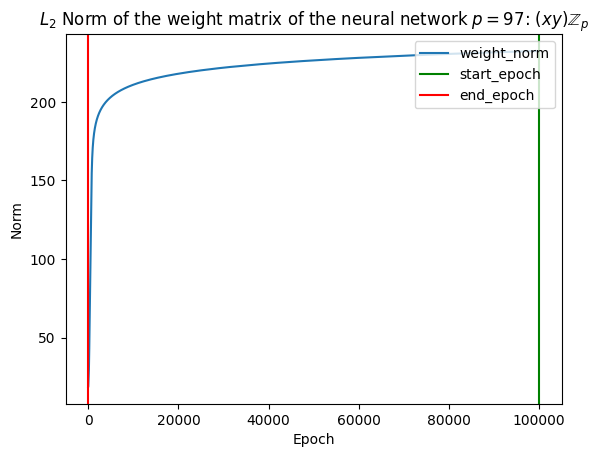

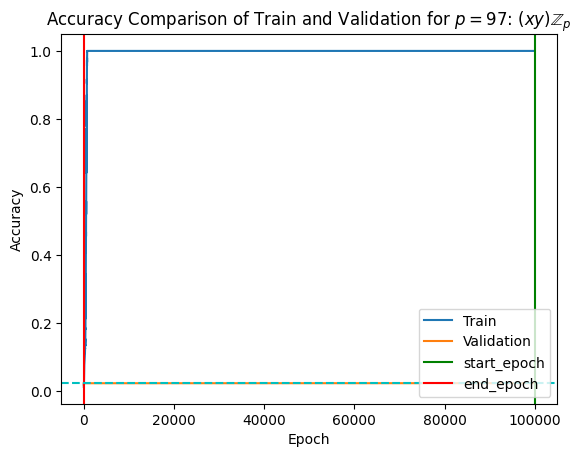

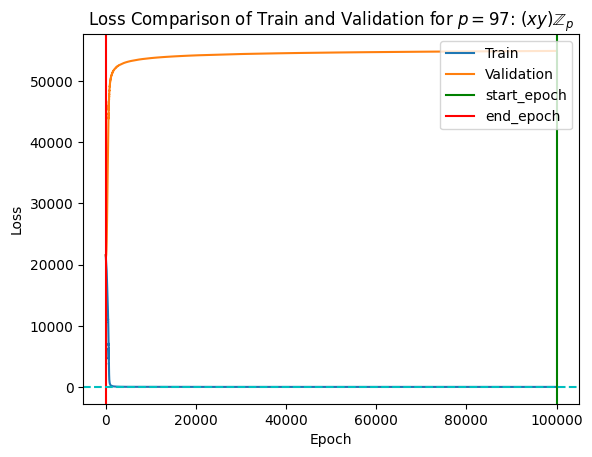

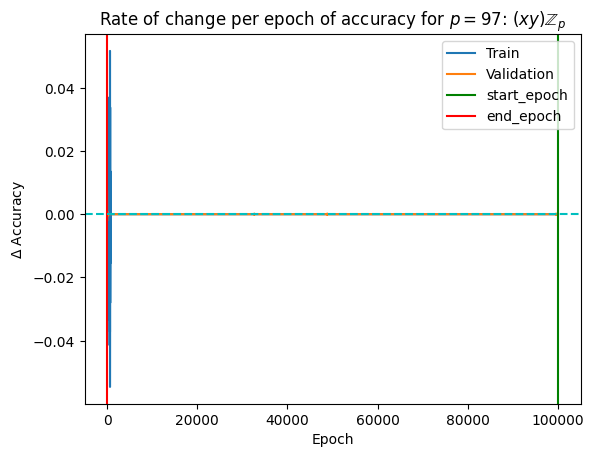

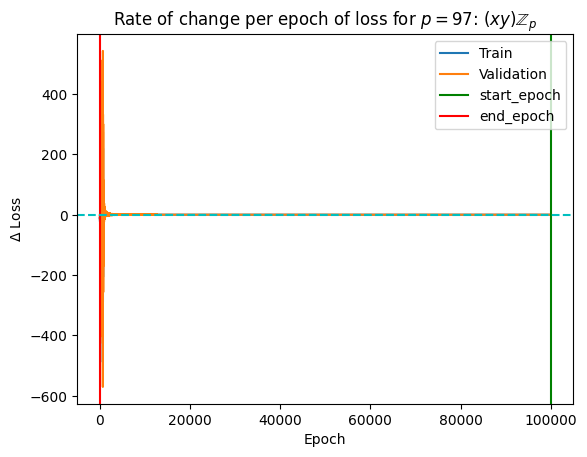

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[(14, 42), (20, 89), (90, 9), (46, 15), (88, 11), (93, 54), (60, 29), (29, 23), (13, 57), (65, 96), (38, 29), (93, 18), (75, 50), (69, 72), (38, 88), (18, 39), (49, 66), (96, 59), (3, 69), (56, 6), (11, 11), (62, 84), (69, 35), (75, 78), (59, 91), (45, 63), (1, 34), (52, 4), (45, 7), (48, 29), (46, 48), (30, 45), (58, 88), (75, 67), (54, 69), (2, 71), (46, 21), (16, 10), (41, 26), (38, 22), (51, 23), (17, 77), (66, 64), (45, 64), (31, 53), (35, 39), (54, 40), (22, 79), (31, 71), (26, 81), (8, 13), (15, 13), (8, 6), (17, 79), (87, 9), (83, 27), (27, 32), (19, 85), (78, 56), (84, 52), (20, 82), (65, 81), (30, 38), (29, 93), (93, 62), (94, 57), (68, 5), (6, 41), (15, 89), (63, 3), (18, 94), (83, 23), (76, 78), (13, 16), (29, 49), (9, 59), (28, 43), (71, 71), (14, 15), (54, 6), (40, 68), (30, 63), (94, 81), (55, 72), (51, 56), (3, 76), (16, 26), (5, 58), (31, 61), (83, 63), (74, 71), (25, 53), (7, 54), (32, 42), (5, 

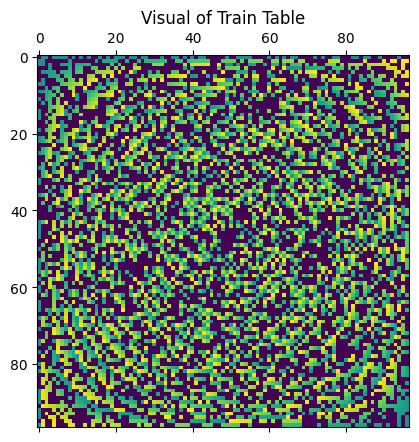

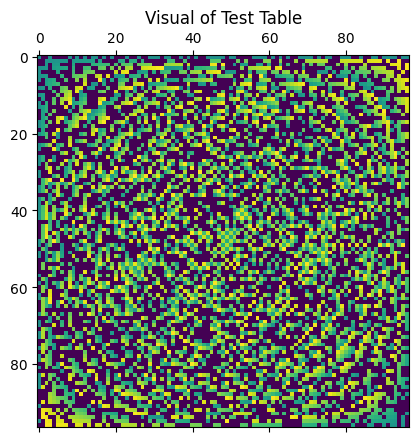

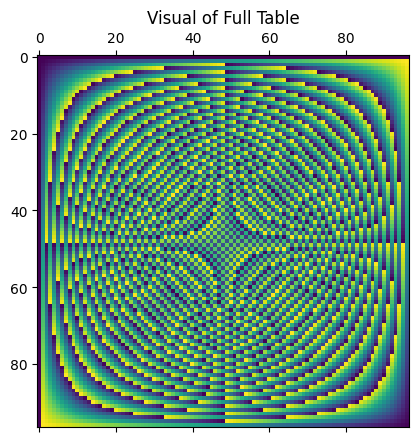

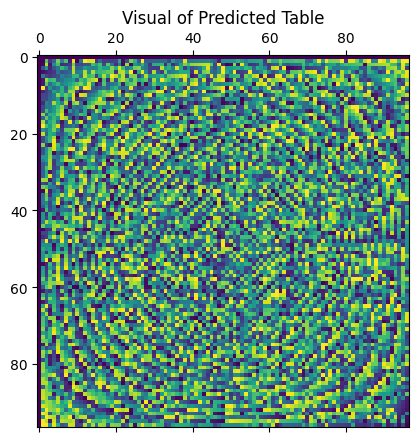


Metric for learning difficulty (New) 0.0012460653584451555


In [ ]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
model = MLP_Grok1(prime, hidden_dim)
threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 2 (My method)

  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy  ->  0.008926673792302608
Train accuracy ->  0.013180271722376347
Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.1687925159931183
Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.6749574542045593
Test accuracy  ->  0.021891603246331215
Train accuracy ->  0.7738094925880432
Test accuracy  ->  0.022529223933815956
Train accuracy ->  0.9238945245742798
Test accuracy  ->  0.02444208227097988
Train accuracy ->  0.9757652878761292
Test accuracy  ->  0.025079701095819473
Train accuracy ->  0.9938350319862366
Test accuracy  ->  0.028055259957909584
Train accuracy ->  0.995535671710968
Test accuracy  ->  0.02911795862019062
Train accuracy ->  0.9993622303009033
Test accuracy  ->  0.03613177314400673
Train accuracy ->  0.9991496205329895
Test accuracy  ->  0.0422954298555851
Train accuracy ->  1.0
Test accuracy  ->  0.06461211293935776
Train accuracy ->  1.0
Test accuracy  ->  0.08544101566076279
Train accuracy ->  1.0
Test accuracy  ->  0.12582358717918396


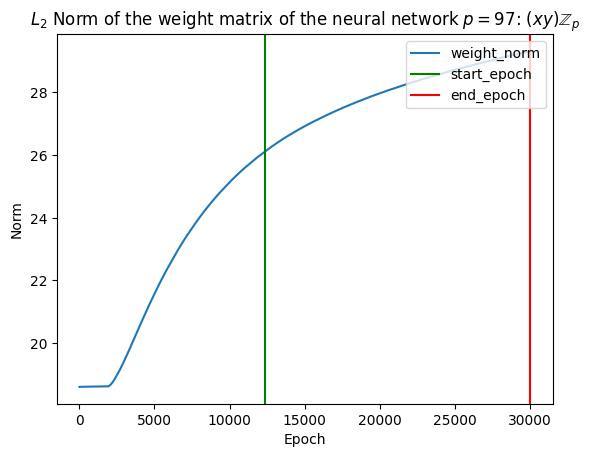

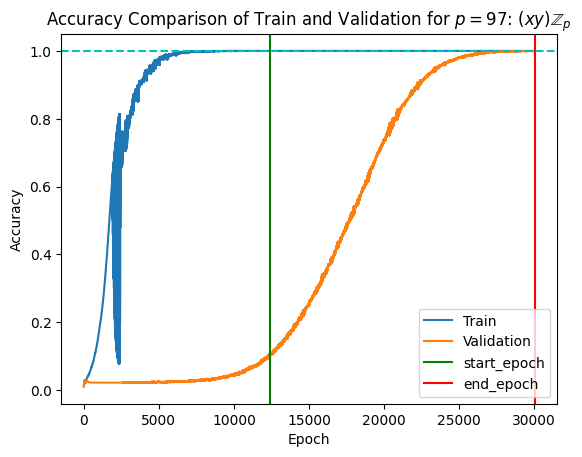

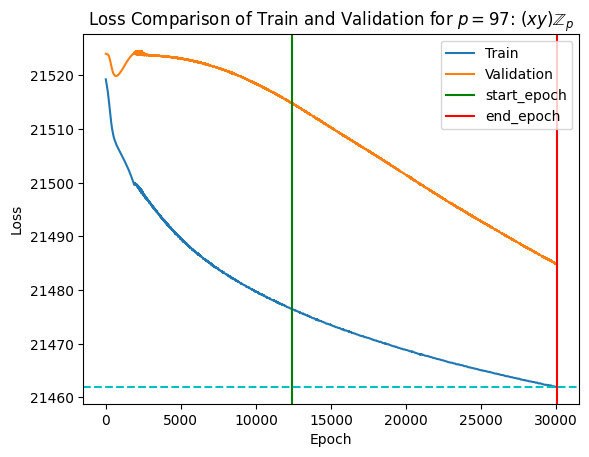

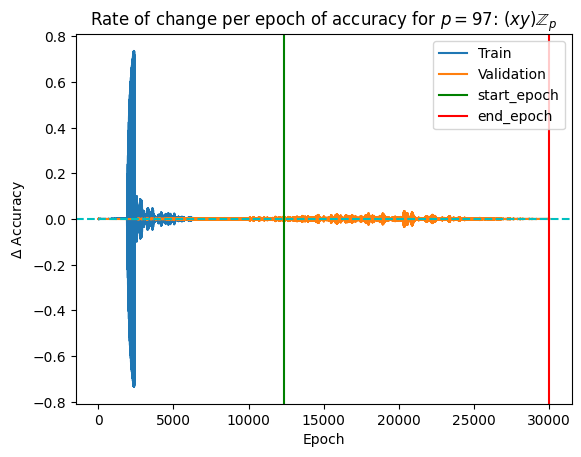

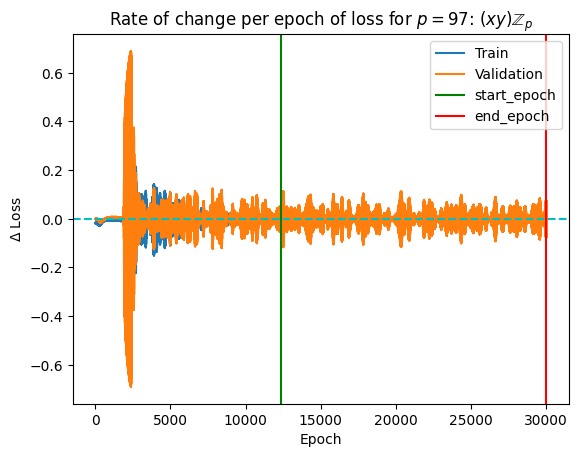

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[]
Metric for learning difficulty (Old) 0.020555384733938618


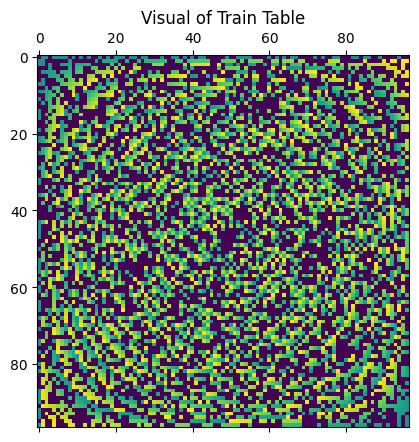

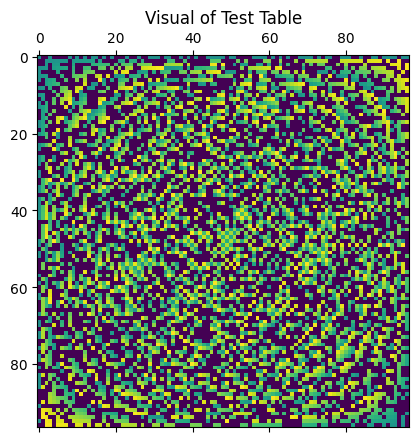

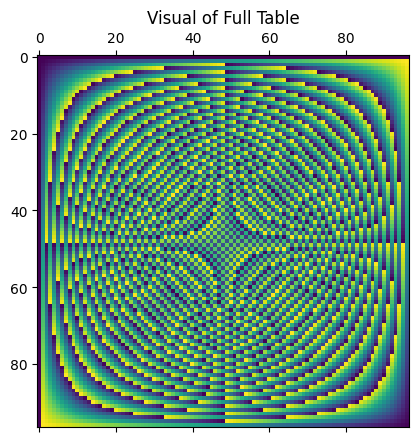

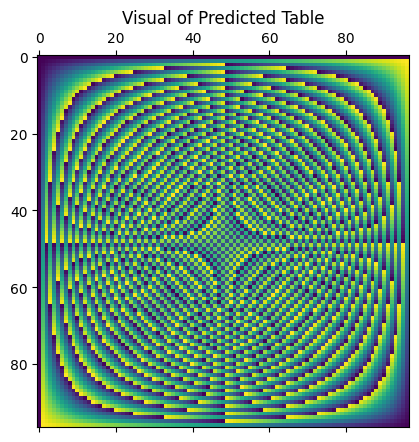


Metric for learning difficulty (New) 0.0012460653584451555


In [6]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime

threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 3

  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy  ->  0.021679064258933067
Train accuracy ->  0.011692176572978497
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.13347502052783966
Train accuracy ->  1.0
Test accuracy  ->  0.49351751804351807
Train accuracy ->  1.0
Test accuracy  ->  0.7764080762863159
Train accuracy ->  1.0
Test accuracy  ->  0.9156216382980347
Train accuracy ->  1.0
Test accuracy  ->  0.971307098865509
Train accuracy ->  1.0
Test accuracy  ->  0.9883102774620056
Train accuracy ->  1.0
Test accuracy  ->  0.9948990345001221
Train accuracy ->  1.0
Test accuracy  ->  0.997449517250061
Train accuracy ->  1.0
Test accuracy  ->  0.9980871081352234
Train accuracy ->  1.0
Test accuracy  ->  0.9993623495101929
Train accuracy ->  1.0
Test accuracy  ->  0.9993623495101929
Train accuracy ->  1.0
Test accuracy  ->  0.999787449836731
Train accuracy ->  1.0
Early stopping: Test accuracy is 100%

50 % of data for training



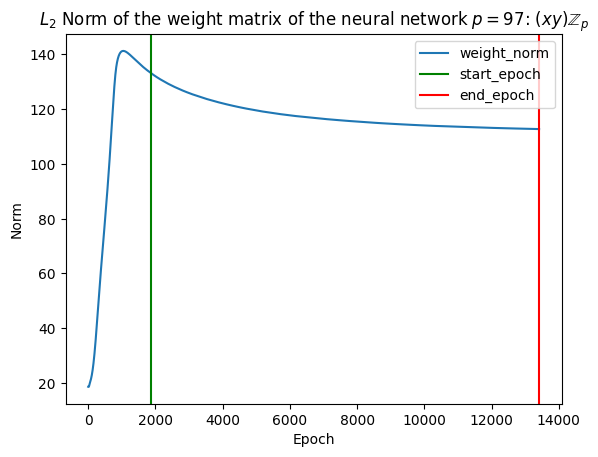

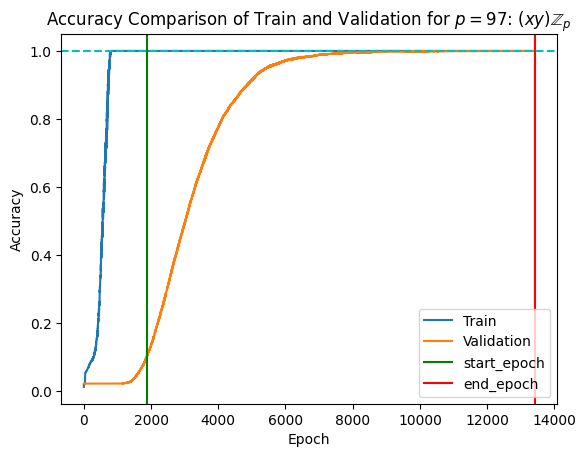

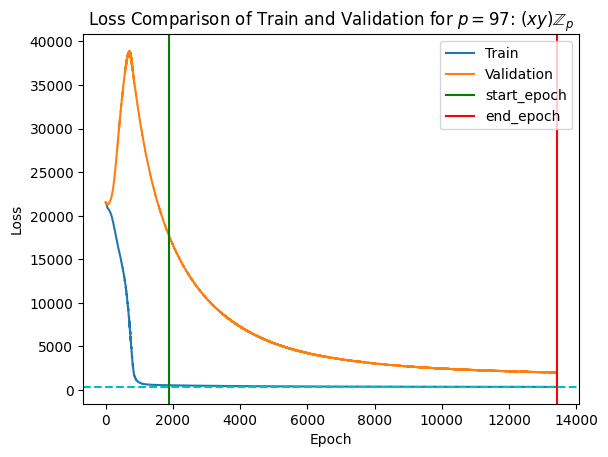

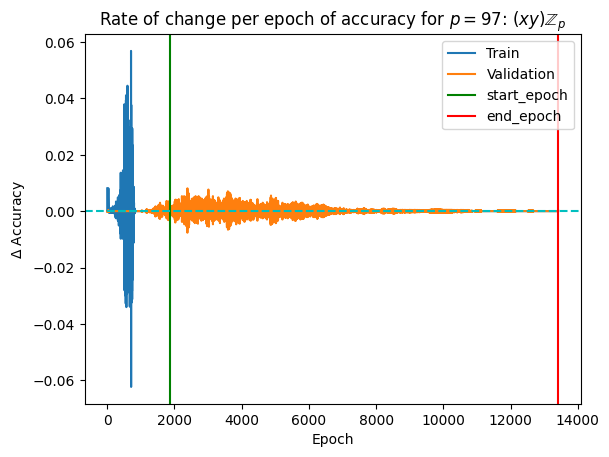

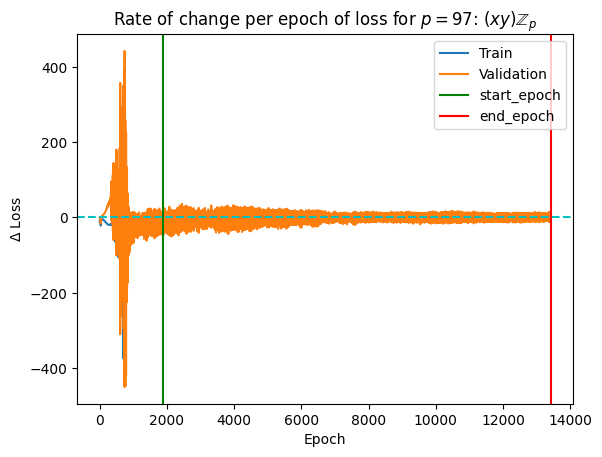

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[]
Metric for learning difficulty (Old) 0.020555384733938618


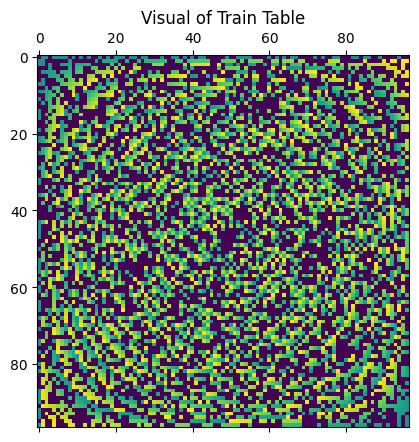

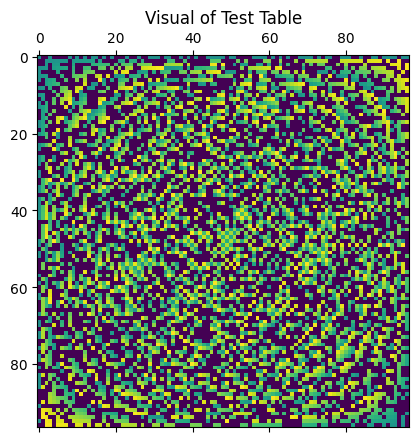

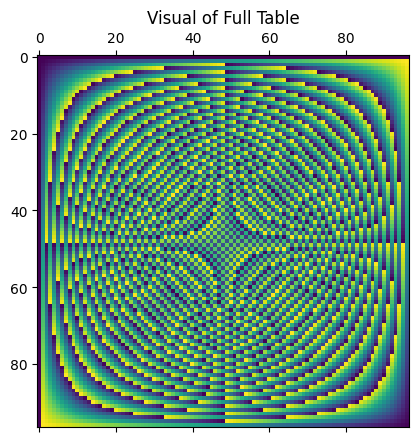

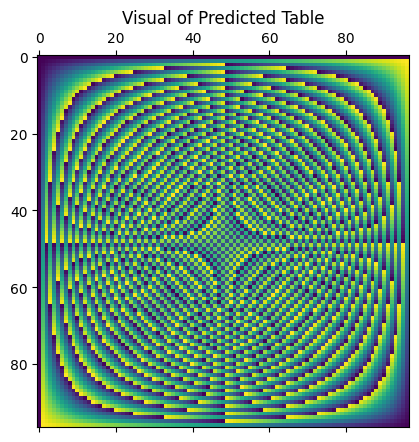


Metric for learning difficulty (New) 0.0012460653584451555


In [7]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
weight_decay = 0.7
threshold1 = 0.9
threshold2 = 1.0
model = MLP_Grok1(prime, hidden_dim)        # Ensuring their is no post logit-activation
run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim, weight_decay = weight_decay)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 4

  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  0.00956632662564516
Test accuracy  ->  0.022529223933815956
Train accuracy ->  0.9000850319862366
Test accuracy  ->  0.23251859843730927
Train accuracy ->  0.8945578336715698
Test accuracy  ->  0.7390010356903076
Train accuracy ->  0.9141156077384949
Test accuracy  ->  0.9540913701057434
Train accuracy ->  0.9077380895614624
Test accuracy  ->  0.9934112429618835
Train accuracy ->  0.899022102355957
Test accuracy  ->  0.9991497993469238
Train accuracy ->  0.9056122303009033
Test accuracy  ->  0.999787449836731
Train accuracy ->  0.9122023582458496
Early stopping: Test accuracy is 100%
threshold1 not reached

Largest gap between accuracies of train and test is 0.8871219661086798 at epoch 966

50 % of data for training



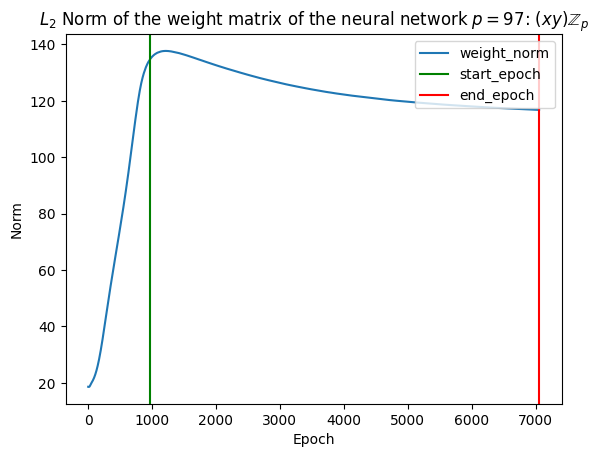

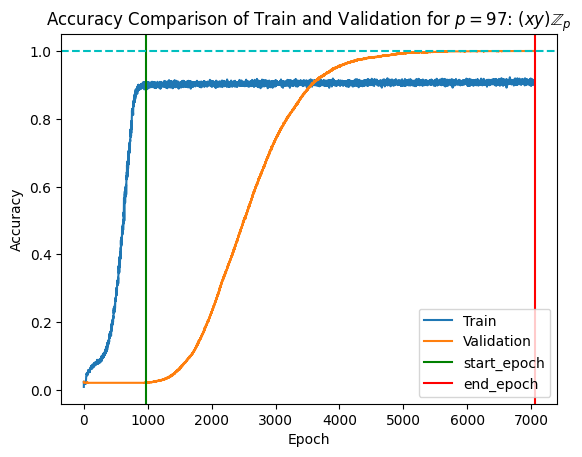

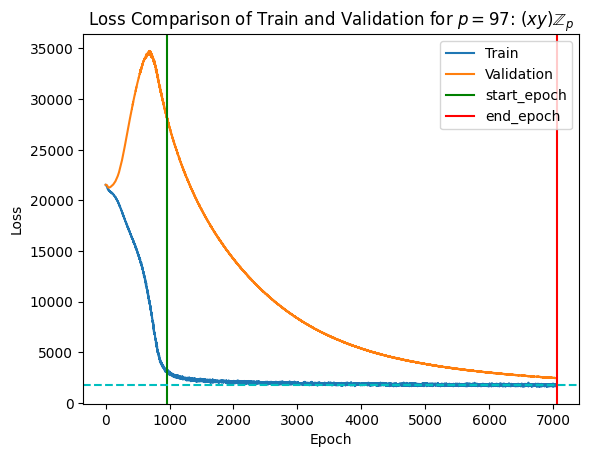

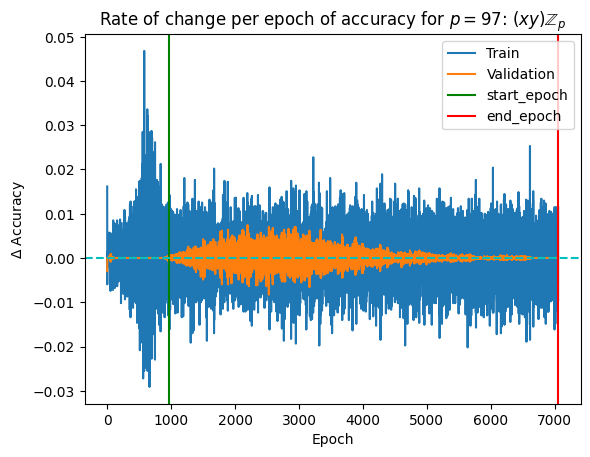

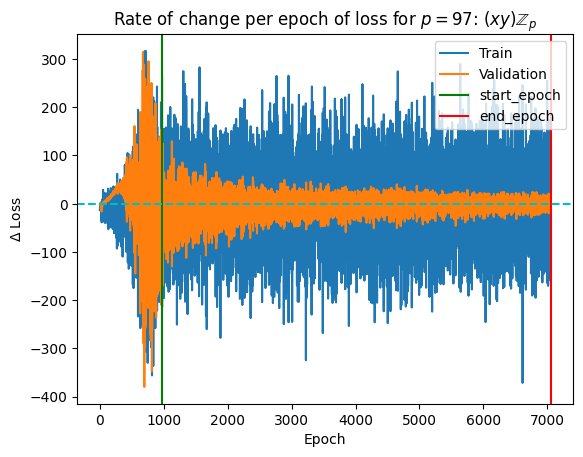

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[]
Metric for learning difficulty (Old) 0.020555384733938618


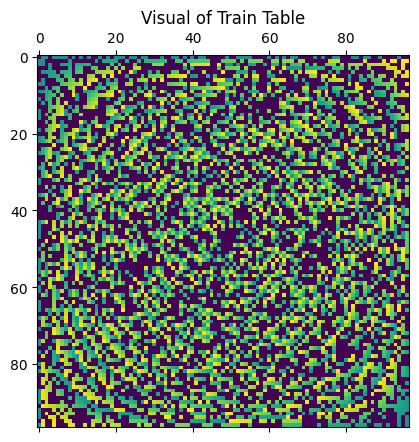

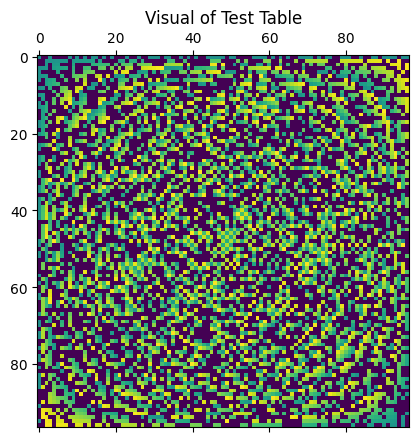

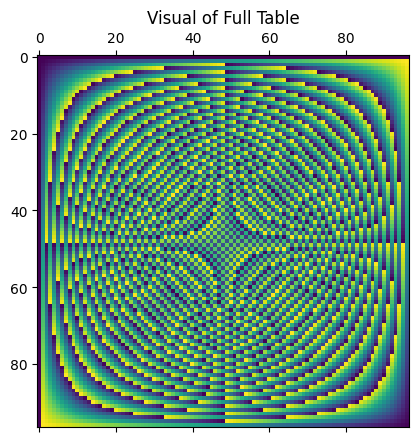

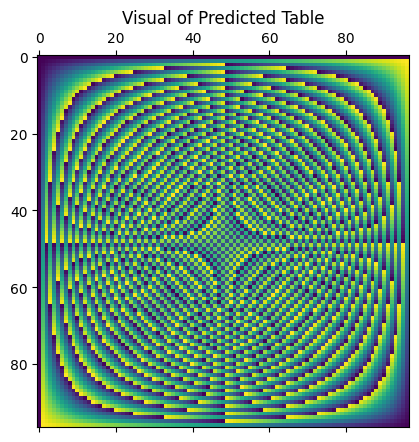


Metric for learning difficulty (New) 0.0012460653584451555


In [8]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
drop_out = 0.1
threshold1 = 0.9
threshold2 = 1.0
model = MLP_Grok3(prime, hidden_dim, drop_out)        # Model with drop out regularisation
run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim, weight_decay = weight_decay)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 5

  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.011267006397247314
Test accuracy  ->  0.02826779894530773
Train accuracy ->  0.039540816098451614
Test accuracy  ->  0.18150903284549713
Train accuracy ->  0.9959608912467957
Test accuracy  ->  0.29946863651275635
Train accuracy ->  1.0
Test accuracy  ->  0.3202975392341614
Train accuracy ->  1.0
Test accuracy  ->  0.3319872319698334
Train accuracy ->  1.0
Test accuracy  ->  0.34133899211883545
Train accuracy ->  1.0
Test accuracy  ->  0.3500531315803528
Train accuracy ->  1.0
Test accuracy  ->  0.35494154691696167
Train accuracy ->  1.0
Test accuracy  ->  0.3600425124168396
Train accuracy ->  1.0
Test accuracy  ->  0.36386820673942566
Train accuracy ->  1.0
Test accuracy  ->  0.3672688603401184
Train accuracy ->  1.0
Test accuracy  ->  0.3693942427635193
Train accuracy ->  1.0
Test accuracy  ->  0.3717322051525116
Train accuracy ->  1.0
Test accuracy  ->  0.3740701377391815
Train accuracy ->  1.0
Test accuracy  ->  0.37555789

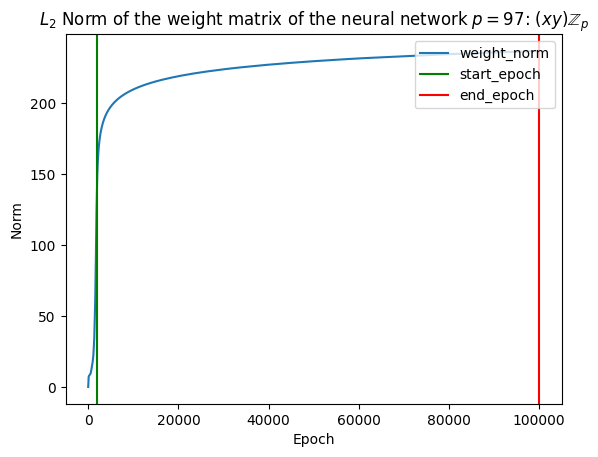

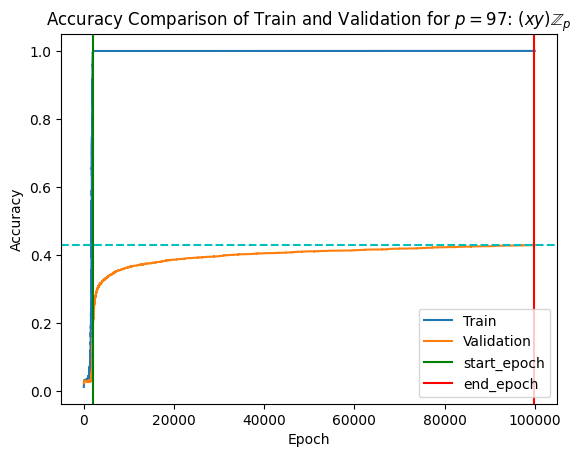

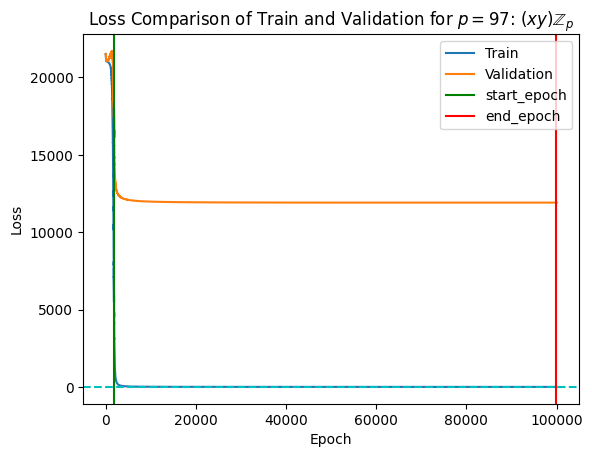

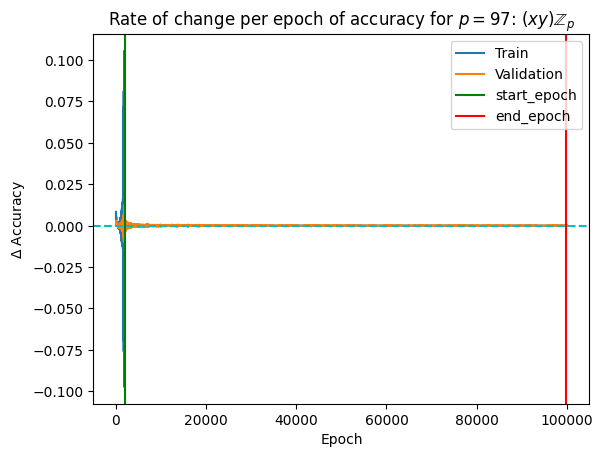

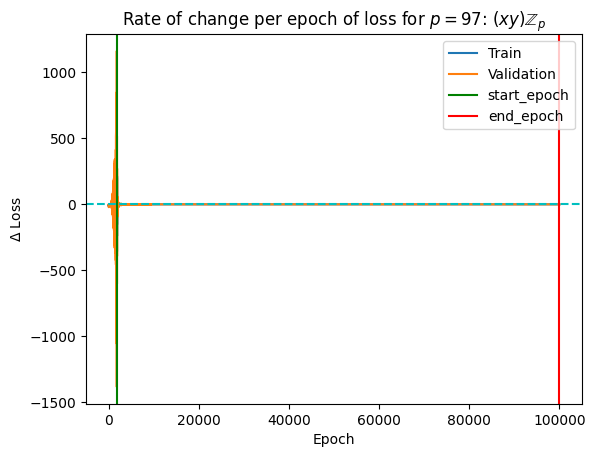

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[(14, 42), (20, 89), (88, 11), (60, 29), (29, 23), (65, 96), (38, 29), (93, 18), (69, 72), (49, 66), (96, 59), (56, 6), (11, 11), (62, 84), (1, 34), (30, 45), (58, 88), (75, 67), (54, 69), (2, 71), (41, 26), (51, 23), (17, 77), (66, 64), (31, 53), (35, 39), (22, 79), (31, 71), (8, 13), (8, 6), (17, 79), (83, 27), (27, 32), (78, 56), (20, 82), (65, 81), (94, 57), (6, 41), (63, 3), (83, 23), (76, 78), (13, 16), (29, 49), (28, 43), (71, 71), (54, 6), (30, 63), (94, 81), (3, 76), (31, 61), (83, 63), (92, 91), (67, 84), (72, 27), (34, 72), (58, 34), (12, 16), (28, 37), (87, 81), (70, 72), (15, 95), (17, 72), (90, 59), (90, 3), (39, 12), (65, 89), (40, 4), (11, 80), (25, 73), (51, 3), (41, 45), (66, 48), (68, 91), (95, 79), (41, 66), (37, 60), (2, 73), (41, 78), (16, 54), (7, 86), (56, 33), (4, 59), (21, 8), (56, 70), (95, 72), (35, 75), (31, 14), (21, 73), (16, 41), (71, 35), (59, 39), (26, 4), (52, 54), (84, 94), (48

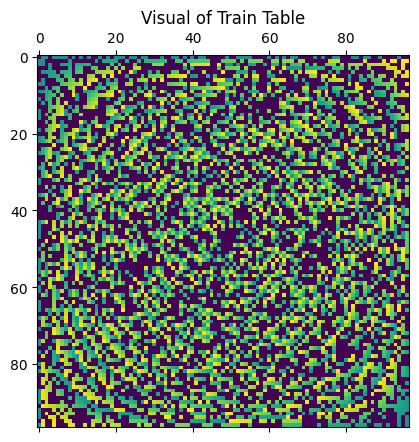

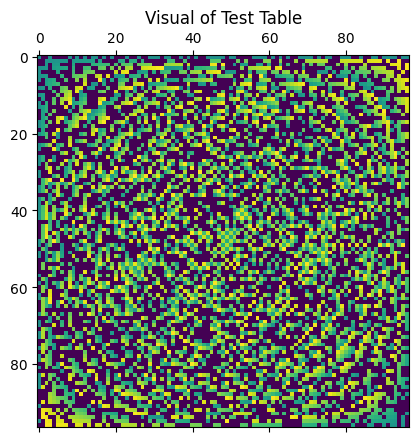

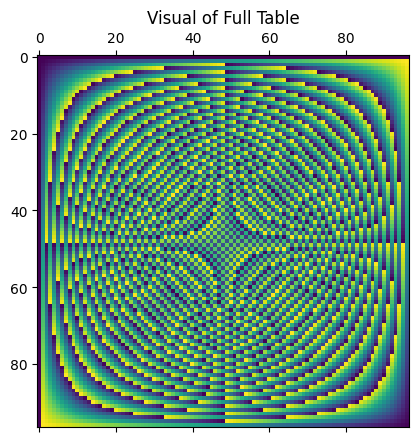

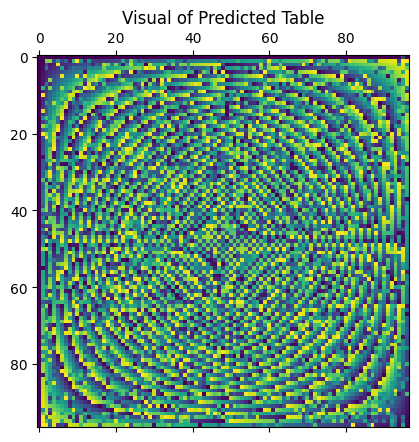


Metric for learning difficulty (New) 0.0012460653584451555


In [9]:
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
model = MLP_Grok1(prime, hidden_dim)            # Model without post-logit activation

with torch.no_grad():
    for name, W in model.named_parameters():
        if 'weight' in name:
            W /= 100_000

threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 6 (Prieto et al.)

  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  0.013180271722376347
Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.9498299360275269
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0
Test accuracy  ->  0.021891603246331215
Train accuracy ->  1.0
Test accuracy  ->  0.02210414409637451
Train accuracy ->  1.0
Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0
Test accuracy  ->  0.022529223933815956
Train accuracy ->  1.0
Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0
Test accuracy  ->  0.02380446344614029
Train accuracy ->  1.0
Test accuracy  ->  0.024017002433538437
Train accuracy ->  1.0
Test accuracy  ->  0.02529224194586277
Train accuracy ->  1.0
Test accuracy  ->  0.025929860770702362
Train accuracy ->  1.0
Test accuracy  ->  0.02614240162074566
Train accuracy ->  1.0
Test accuracy  ->  0.027205100283026695
Train accuracy ->  1.0
Test accuracy  ->  0.0278427191

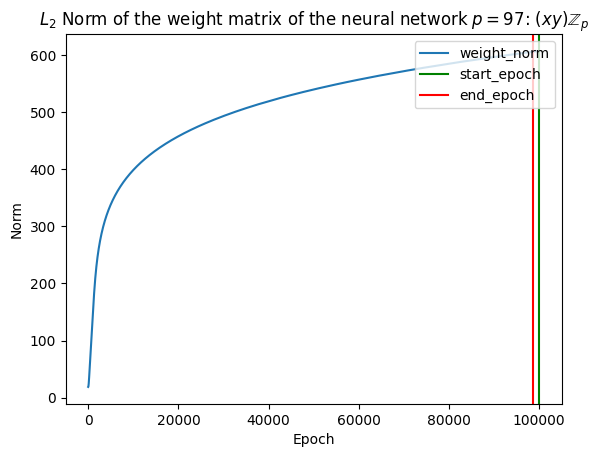

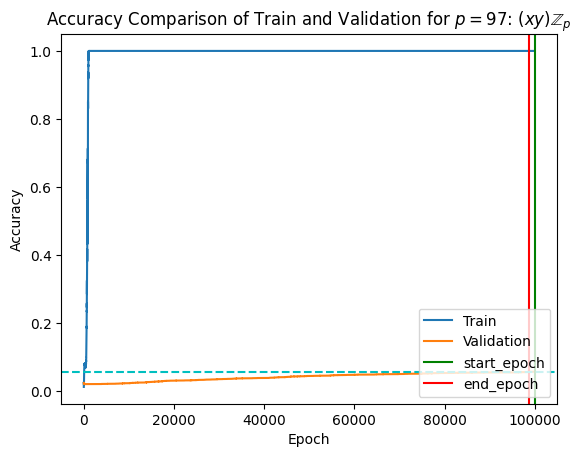

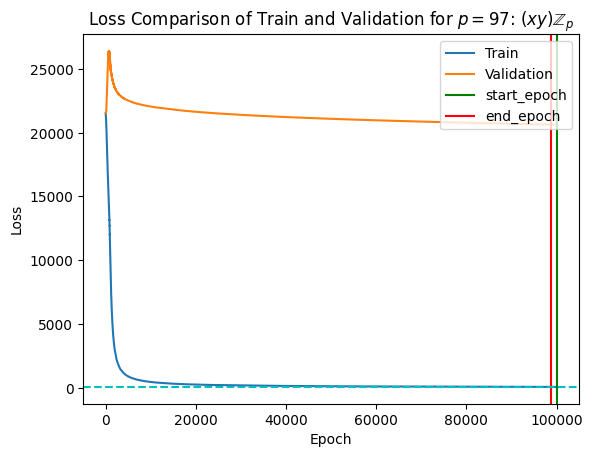

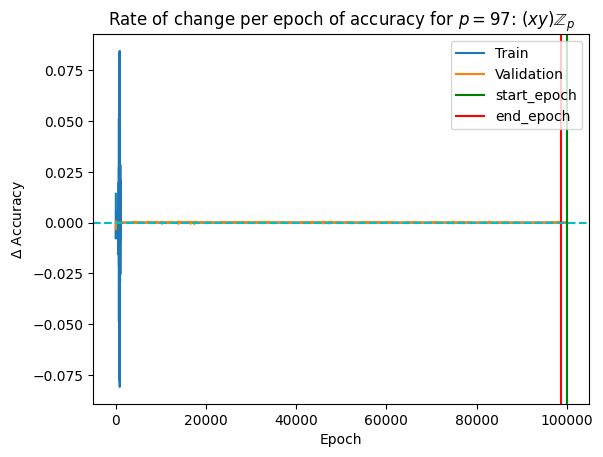

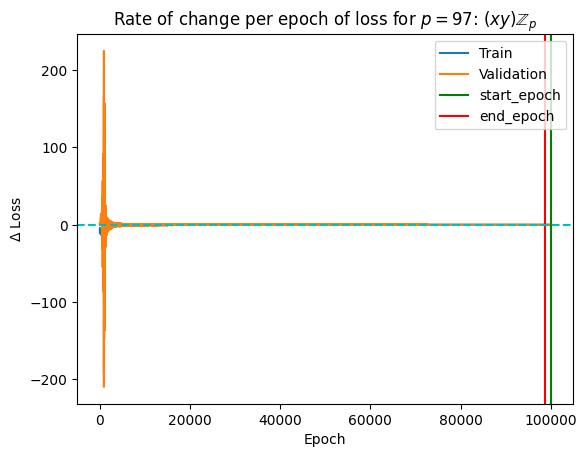

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[(14, 42), (20, 89), (90, 9), (46, 15), (88, 11), (93, 54), (60, 29), (29, 23), (13, 57), (65, 96), (38, 29), (93, 18), (75, 50), (69, 72), (38, 88), (18, 39), (49, 66), (96, 59), (3, 69), (11, 11), (62, 84), (69, 35), (75, 78), (59, 91), (45, 63), (1, 34), (52, 4), (45, 7), (48, 29), (46, 48), (30, 45), (58, 88), (75, 67), (54, 69), (2, 71), (46, 21), (41, 26), (38, 22), (51, 23), (17, 77), (66, 64), (45, 64), (31, 53), (35, 39), (54, 40), (22, 79), (31, 71), (26, 81), (8, 13), (8, 6), (17, 79), (87, 9), (83, 27), (27, 32), (19, 85), (78, 56), (84, 52), (20, 82), (65, 81), (30, 38), (29, 93), (93, 62), (94, 57), (68, 5), (6, 41), (63, 3), (18, 94), (83, 23), (76, 78), (13, 16), (29, 49), (9, 59), (28, 43), (71, 71), (14, 15), (54, 6), (40, 68), (30, 63), (94, 81), (55, 72), (51, 56), (3, 76), (16, 26), (5, 58), (31, 61), (83, 63), (74, 71), (25, 53), (7, 54), (32, 42), (5, 33), (92, 91), (67, 84), (72, 27), (34,

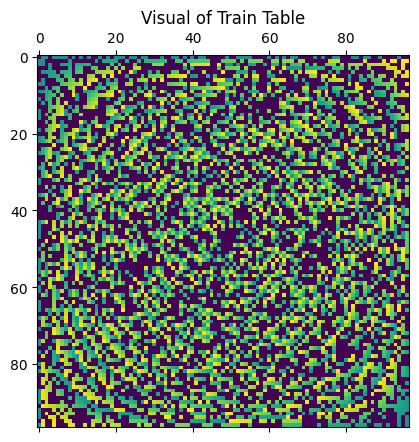

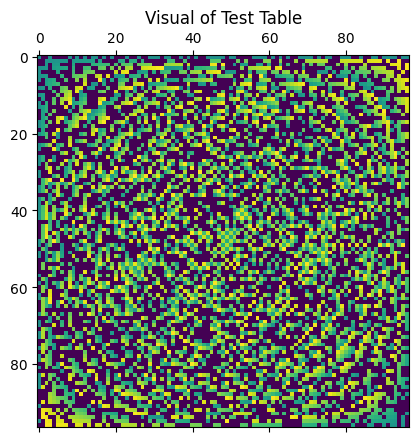

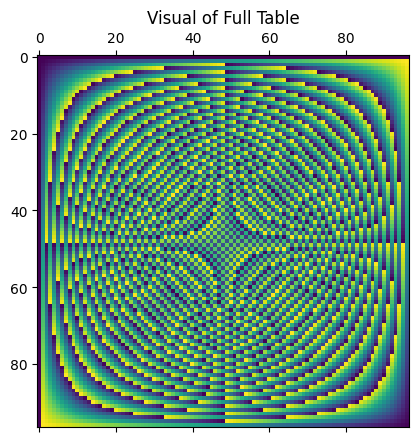

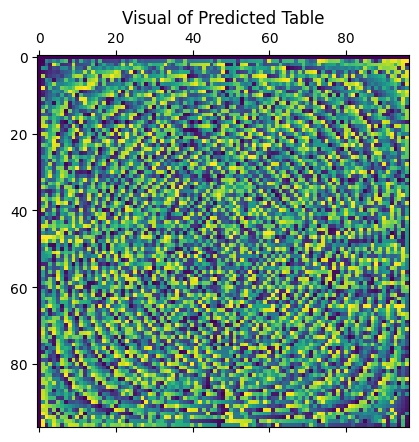


Metric for learning difficulty (New) 0.0012460653584451555


In [10]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
model = MLP_Grok4(prime, hidden_dim)             # Model Prieto
threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

# Notes

1. So far, my metrics have not shown substantial correlation to grokking difficulty. Also, I can see from the plots that it might be better to consider some sort of measure of symmetry of the tables as against randomness of the tables to get this metric. I will work on that.
2. I have also observed that the sweet spot for the size of the table to experiment with for Grokking is $67 \times 67$ (although needing about $5$ times number of epochs for $97 \times 97$). This suggests that the amount of data is a critical factor of grokking. I shall study this "edge" case more to craft my metric.
3. I have observed that ReLU activation gives the best performance, but the networks should not be too wide (approximately $2.5$ times the first layer is good) to avoid slow learning. The new activation function at the output (projection on the $L_2$ unit ball) was a game changer. I might try other $L_p$ norm unit balls.
4. I have not played with soem hyper-parameters and so on like learning rate, loss function, weight decay, drop out. This is because of how computationally expensive the experiments are.
5. Multiplication for prime squares e.g. 121, behave like primes, while for very composite numbers, e.g. 72, grokking is more difficult
6. Constant mapping is learnt in 1 epoch, but random noise is only memorised so far.